<h1 align=center style="background: #1255e7; color: #ebebeb " > <br> Test Project - Dataset of a Belarusian Bank <br> </font></h1> <br>

<h3 align = right style="margin-top: 0"> Sergey Fialka </h3>
<h4 align = right style="margin-top: 0"> sergey.fialka@gmail.com </h4>
<h4 align = right style="margin-top: 0"> <a href="https://linkedin.com/in/sergey-fialka/"> linkedin.com/in/sergey-fialka/ </a></h4>

# Content

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>    

1. <a href="#item1"> Import Libraries and Data </a><br>
2. <a href="#item2"> Data Wrangling </a><br>
3. <a href="#item3"> Exploratory Data Analysis </a><br>
<div> <font size = 2>  
   3.1 <a href="#item31"> EMPL_ALL_EXP </a> <br>
   3.2 <a href="#item32"> REALTY_EXIST </a> <br>
   3.3 <a href="#item33"> HOUSE_COND </a> <br>
   3.4 <a href="#item34"> MARR_STAT </a> <br>
   3.5 <a href="#item35"> CUST_DUR_YEAR </a> <br>
</font> </div>
4. <a href="#item4"> Model Development and Evaluation </a>  

</font>
    
</div>

<a id="item1"></a> 
<h1 align= center>Import Libraries and Data</h1>

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks")
sns.set_context("notebook", font_scale=1.2)
import missingno

import sklearn
print("scikit-learn ver.",sklearn.__version__)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

import xgboost 
print("xgboost ver.",xgboost.__version__)
from xgboost import XGBClassifier

print("Import Complete!\n----------------")

## Import Data
train_data = pd.read_csv("train.csv",sep=';')
print("train dataset size -",train_data.shape)

test_data = pd.read_csv("test.csv",sep=';')
print("test dataset size -",test_data.shape)

scikit-learn ver. 0.23.1
xgboost ver. 1.1.1
Import Complete!
----------------
train dataset size - (67949, 87)
test dataset size - (29125, 86)


<a id="item2"></a> 
<h1 align= center>Data Wrangling</h1>

#### • Identify missing values :

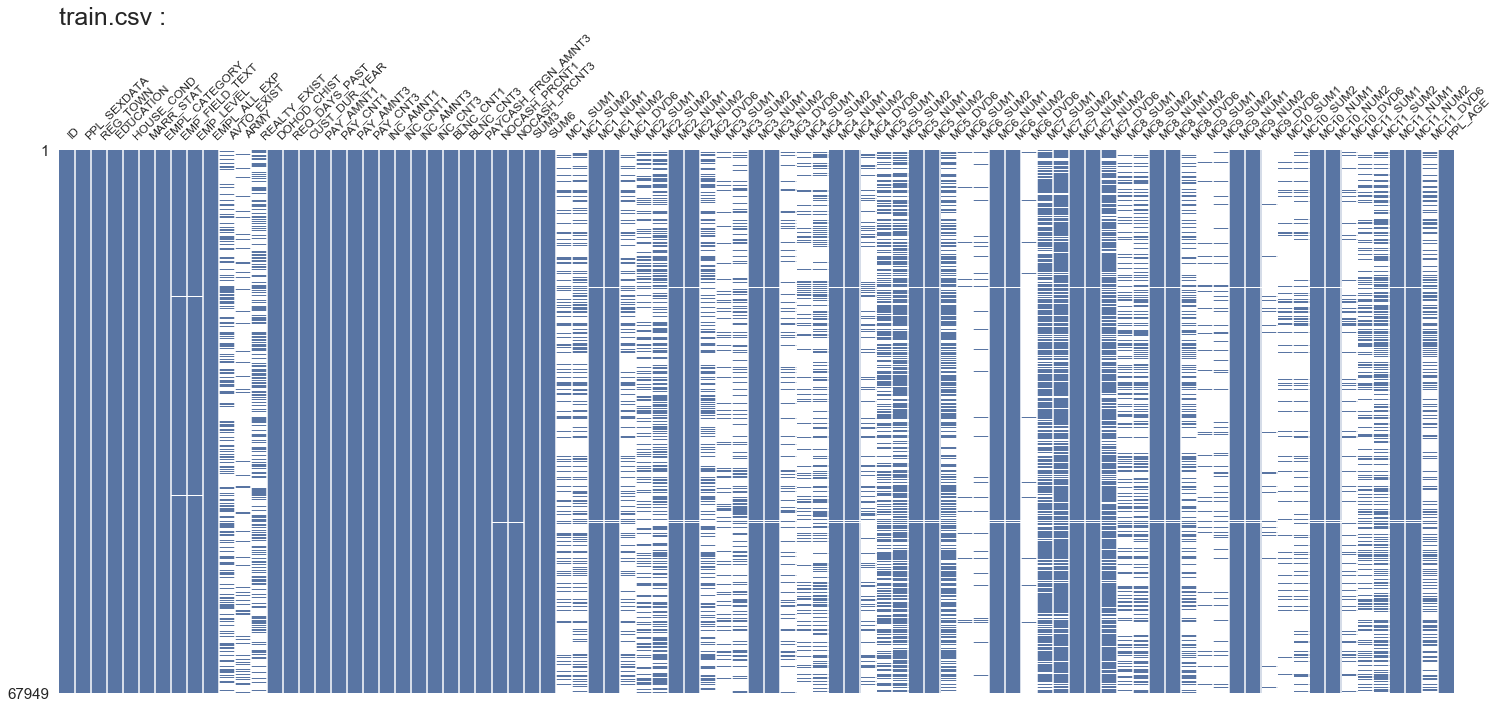

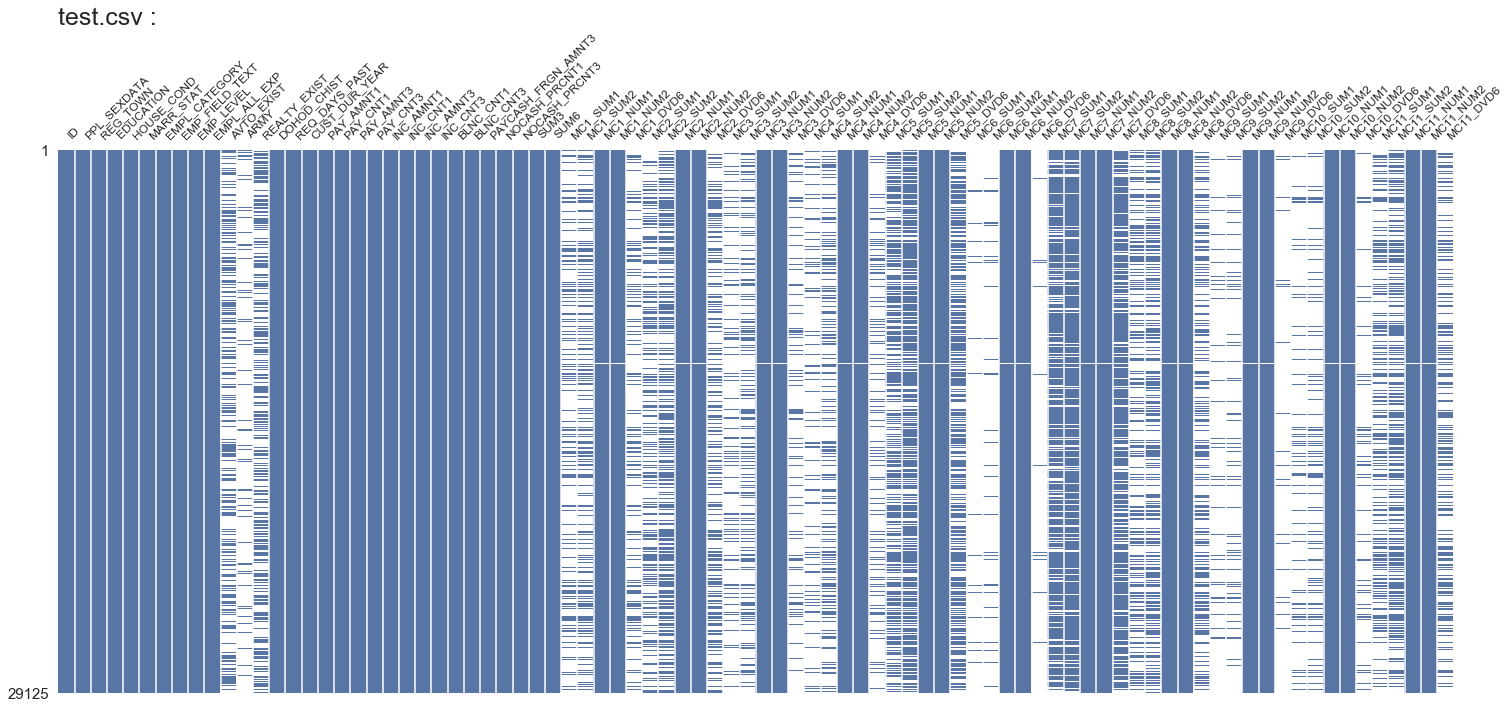

In [2]:
# Visualize the missing row for each columns
missingno.matrix(train_data, fontsize = 12,labels=True, color=(0.34902, 0.458824, 0.643137), sparkline=False)
plt.title("train.csv :", fontsize=25, loc = 'left')
plt.show()

missingno.matrix(test_data, fontsize = 12,labels=True, color=(0.34902, 0.458824, 0.643137), sparkline=False) 
plt.title("test.csv :", fontsize=25, loc = 'left')
plt.show()

We can see that both data sets have the same structure.

#### • Let's make sure there are no duplicates :

In [3]:
train_data['ID'].duplicated().sum()

0

**• Let's drop the fields containing data for 1 month**, since they are already contained in the fields with data for 3 months (if the data for 1 month has a permanent statistical relationship with the age of the client, then this connection should also be observed in the data for 3 months ) : 

In [4]:
# drop feature "for 1 mounth"

features_1m = [column for column in train_data.columns if column[-1] == '1'] 
        
train_data.drop(features_1m, axis=1, inplace = True)
test_data.drop(features_1m, axis=1, inplace = True)

print('Удалено '+str(len(features_1m))+' "признаков" : ', features_1m)

Удалено 28 "признаков" :  ['PAY_AMNT1', 'PAY_CNT1', 'INC_AMNT1', 'INC_CNT1', 'BLNC_CNT1', 'NOCASH_PRCNT1', 'MC1_SUM1', 'MC1_NUM1', 'MC2_SUM1', 'MC2_NUM1', 'MC3_SUM1', 'MC3_NUM1', 'MC4_SUM1', 'MC4_NUM1', 'MC5_SUM1', 'MC5_NUM1', 'MC6_SUM1', 'MC6_NUM1', 'MC7_SUM1', 'MC7_NUM1', 'MC8_SUM1', 'MC8_NUM1', 'MC9_SUM1', 'MC9_NUM1', 'MC10_SUM1', 'MC10_NUM1', 'MC11_SUM1', 'MC11_NUM1']


#### • Overview of Fields with a Non-Numeric Data Type:

In [5]:
# select features with not numeric data type
notNmericFeatures = train_data\
                        .dtypes\
                        .loc[(train_data.dtypes != 'int64') & (train_data.dtypes != 'float64')]\
                        .rename('type')\
                        .to_frame()\
                            .join(train_data.describe(include = 'all').loc['top'].to_frame())\
                            .join(train_data.describe(include = 'all').loc['unique'].to_frame())

# count values with all alphabetic characters 
notNmericFeatures['n_alpha_values'] = [train_data[features].str.isalpha().sum() for features in notNmericFeatures.index ]
# count values with all digit characters 
notNmericFeatures['n_digit_values'] = [train_data[features].str.isdigit().sum() for features in notNmericFeatures.index ]
# count missing values 
notNmericFeatures['n_missing_values'] = [train_data[features].isna().sum() for features in notNmericFeatures.index ]

notNmericFeatures

,type,top,unique,n_alpha_values,n_digit_values,n_missing_values
PPL_SEXDATA,object,F,2,67949,0,0
REG_TOWN,object,МИНСК,2792,66836,0,0
EDUCATION,object,Высшее,8,41354,0,0
HOUSE_COND,object,в собственном доме/квартире,8,93,0,0
MARR_STAT,object,женат/замужем,6,0,0,0
EMPL_CATEGORY,object,Работа/служба по найму,7,55,0,0
EMP_FIELD_TEXT,object,услуги,26,53005,0,57
EMP_LEVEL,object,не руководящий работник,4,0,0,46
ARMY,object,Невоеннообязанный,6,3016,0,61530
DOHOD_CHIST,object,550,27667,0,33896,0


Let's consider in more detail the fields, which contain data with digits :   

In [6]:
train_data[notNmericFeatures.index[notNmericFeatures['n_digit_values'] > 0]].head()

,DOHOD_CHIST,PAY_AMNT3,INC_AMNT3,PAYCASH_FRGN_AMNT3,NOCASH_PRCNT3,SUM3,SUM6,MC1_SUM2,MC1_DVD6,MC2_SUM2,...,MC7_SUM2,MC7_DVD6,MC8_SUM2,MC8_DVD6,MC9_SUM2,MC9_DVD6,MC10_SUM2,MC10_DVD6,MC11_SUM2,MC11_DVD6
0,320,"2025,55",620,0,"0,7656","2025,55","343,47","23,96",NaN,"261,17",...,"1456,22","6,2354",NaN,NaN,"5,21","0,0321",NaN,NaN,"34,19","3,0531"
1,"1052,58","1284,4",620,0,"0,676","1284,4","515,22",NaN,NaN,NaN,...,"94,34","0,5414","512,81","2,1012",NaN,NaN,NaN,NaN,NaN,NaN
2,"680,82","1528,56",1345,0,"0,5319","1528,56","860,55",NaN,NaN,NaN,...,"556,57","1,4553","615,71","0,7794",NaN,NaN,NaN,NaN,"6,84",NaN
3,300,"2888,05","3171,13","27,99","0,7924","2888,05","2122,88","43,26","1,9875",20,...,"934,75","1,4862","611,96","1,4753","0,81",NaN,"2,5","0,9646","25,57",NaN
4,560,"434,86",0,0,1,"434,86","488,02",NaN,NaN,NaN,...,"347,59","0,9201","66,65","0,8875",NaN,NaN,NaN,NaN,"4,62","1,1256"


It can be seen that these fields contain only digits (partially with a comma), therefore we can change the data type of these fields to <code> float </code>:

In [7]:
# assign 'float' data type to properly features

def convertToFloat(pdSeries):
    return pdSeries.map(str).map(lambda x: x.replace(',','.')).astype('float')
    
for column in notNmericFeatures.index[notNmericFeatures['n_digit_values'] > 0] : 
    train_data[column] = convertToFloat(train_data[column])
    test_data[column] = convertToFloat(test_data[column])

___
<br> 
The **ARMY** feature contains a large amount of missing values. Let's see what categories it contains :

In [8]:
print(train_data['ARMY'].unique())

[nan 'В запасе/отставке' 'Военнослужащий' 'Невоеннообязанный'
 'Призывник, нет отсрочки' 'Призывник, есть отсрочка до'
 'Прошедший альтернативную службу']


We can see that the categories of **ARMY** field cover all types of membership in the armed forces, while most of the values are missing. Let's consider this feature separately for women and men : 

In [9]:
print('F:')
print("null\t\t",train_data.loc[train_data['PPL_SEXDATA']=="F",'ARMY'].isna().sum())
print(train_data.loc[train_data['PPL_SEXDATA']=="F",'ARMY'].value_counts())
print('\nM:')
print("null\t\t\t\t",train_data.loc[train_data['PPL_SEXDATA']=="M",'ARMY'].isna().sum())
print(train_data.loc[train_data['PPL_SEXDATA']=="M",'ARMY'].value_counts())

F:
null		 41140
Невоеннообязанный    18
Name: ARMY, dtype: int64

M:
null				 20390
Невоеннообязанный                  2267
В запасе/отставке                  2104
Призывник, есть отсрочка до         992
Военнослужащий                      731
Прошедший альтернативную службу     262
Призывник, нет отсрочки              45
Name: ARMY, dtype: int64


In [10]:
train_data.loc[(train_data['PPL_SEXDATA']=="M") & (train_data['ARMY'].isna()),['PPL_AGE','PPL_SEXDATA','ARMY']].describe()

,PPL_AGE
count,20390.000000
mean,37.499166
std,5.770308
min,21.000000
25%,33.000000
50%,37.000000
75%,42.000000
max,50.000000


We see that most of the missing values refers to women, we mark them as 'Невоеннообязанный'. The remaining missing values is mainly refers to men over 27, mark them as 'В запасе/отставке' :

In [11]:
train_data.loc[train_data['PPL_SEXDATA']=="F",'ARMY'] = 'Невоеннообязанный'
train_data['ARMY'].fillna('В запасе/отставке',inplace = True)

test_data.loc[test_data['PPL_SEXDATA']=="F",'ARMY'] = 'Невоеннообязанный'
test_data['ARMY'].fillna('В запасе/отставке',inplace = True)

____
<br> 
Consider **REG_TOWN** field: 

In [12]:
print('Number of settlements in train data set =', train_data['REG_TOWN'].nunique())

Number of settlements in train data set = 2792


Since not all possible settlements are contained in the training data set,**we will combine the settlements with a population of up to 100 thousand people to the group 'ДрНасПункты'**:

In [13]:
def groupCities(pdSeries):
    return pdSeries.map(lambda x: x if x in ['МИНСК','ГОМЕЛЬ','МОГИЛЕВ','ВИТЕБСК','ГРОДНО','БРЕСТ',
                                            'БОБРУЙСК', 'БАРАНОВИЧИ', 'БОРИСОВ', 'ПИНСК', 
                                            'ОРША', 'МОЗЫРЬ', 'СОЛИГОРСК', 'НОВОПОЛОЦК', 'ЛИДА'] else 'ДрНасПункты')

train_data['REG_TOWN_simplified'] = groupCities(train_data.pop('REG_TOWN'))
test_data['REG_TOWN_simplified'] = groupCities(test_data.pop('REG_TOWN'))

<br> 
#### • Overview of Fields with a Numeric Data Type::

In [14]:
# select features with 'float' data type
floatFeatures = train_data\
                    .drop(['ID','PPL_AGE'],axis = 1)\
                    .dtypes\
                    .loc[(train_data.dtypes == 'float64') | (train_data.dtypes == 'int64')]\
                    .rename('type')\
                    .to_frame()\
                        .join(train_data.describe().loc['min'].to_frame())\
                        .join(train_data.describe().loc['50%'].to_frame())\
                        .join(train_data.describe().loc['max'].to_frame())

# count unique values 
floatFeatures['n_unique_values'] = [train_data[features].nunique() for features in floatFeatures.index ]
# count missing values 
floatFeatures['n_missing_values'] = [train_data[features].isna().sum() for features in floatFeatures.index ]

floatFeatures

,type,min,50%,max,n_unique_values,n_missing_values
EMPL_ALL_EXP,int64,0.000000e+00,13.00000,3.500000e+01,36,0
AVTO_EXIST,float64,1.000000e+00,1.00000,1.000000e+00,1,41541
REALTY_EXIST,float64,1.000000e+00,1.00000,1.000000e+00,1,39638
DOHOD_CHIST,float64,-2.100000e+06,540.00000,1.127000e+08,27667,0
REQ_DAYS_PAST,int64,9.000000e+00,545.00000,1.833000e+03,1734,0
CUST_DUR_YEAR,int64,0.000000e+00,3.00000,1.800000e+01,18,0
PAY_AMNT3,float64,0.000000e+00,762.35000,1.065262e+05,57997,0
PAY_CNT3,int64,0.000000e+00,27.00000,7.270000e+02,468,0
INC_AMNT3,float64,0.000000e+00,151.39000,3.386122e+05,20706,0
INC_CNT3,int64,0.000000e+00,2.00000,7.300000e+02,152,0


<br> 
We can see that the **MC*_NUM2** fields contain only 0 and 1. According to the instructions, these fields should correspond to the number of transactions, but the content is not consistent with the description. Let us consider in more detail these fields and related ones:

In [15]:
train_data[['MC1_NUM2','MC1_SUM2','MC1_DVD6','MC2_NUM2','MC2_SUM2','MC2_DVD6','MC3_NUM2','MC3_SUM2','MC3_DVD6']]

,MC1_NUM2,MC1_SUM2,MC1_DVD6,MC2_NUM2,MC2_SUM2,MC2_DVD6,MC3_NUM2,MC3_SUM2,MC3_DVD6
0,1.0,23.96,NaN,1.0,261.17,NaN,1.0,11.95,NaN
1,0.0,NaN,NaN,0.0,NaN,NaN,1.0,81.10,9.2785
2,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN
3,1.0,43.26,1.9875,1.0,20.00,1.7423,0.0,NaN,NaN
4,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
67944,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN
67945,0.0,NaN,NaN,1.0,108.29,0.6453,0.0,NaN,NaN
67946,0.0,NaN,NaN,1.0,161.01,NaN,1.0,45.85,NaN
67947,0.0,NaN,NaN,1.0,56.55,0.0961,0.0,NaN,NaN


Looking at the data, we can assume that **MC*_NUM2** fields reflect the fact of the transaction, not quantity, then the empty values in **MC*_SUM2** and **MC*_DVD6** are zeros. Following this statement, let's fill missing values in **MC*_SUM2** and **MC*_DVD6**:

In [16]:
features_NUM2 = [column for column in train_data.columns if 'NUM2' in column] 
features_SUM2 = [column for column in train_data.columns if 'SUM2' in column] 
features_DVD6 = [column for column in train_data.columns if 'DVD6' in column] 

for i,column in enumerate(features_NUM2) :
    train_data.loc[ train_data[column] == 0 , [features_SUM2[i],features_DVD6[i]] ] = 0
    train_data.loc[ (train_data[column] == 1) & (train_data[features_DVD6[i]].isna()) , features_DVD6[i]] = 0
    test_data.loc[  test_data[column]  == 0 , [features_SUM2[i],features_DVD6[i]] ] = 0
    test_data.loc[  (test_data[column] == 1)  & (test_data[features_DVD6[i]].isna())  , features_DVD6[i]] = 0

<br> 
Let's drop the **MC*_NUM2** fields, since they repeat and contain less information than the **MC*_SUM2**:

In [17]:
# drop MC*_NUM features
train_data.drop(features_NUM2, axis=1, inplace = True)
test_data.drop(features_NUM2, axis=1, inplace = True)

___
<br> 
The **REALTY_EXIST** feature contains a large amount of missing values, at the same time it has similar feature :

In [18]:
train_data[['HOUSE_COND','REALTY_EXIST']].head(10)

,HOUSE_COND,REALTY_EXIST
0,в собственном доме/квартире,1.0
1,у родителей,NaN
2,у родителей,NaN
3,у родителей,1.0
4,общежитие/гостиница,NaN
5,служебное жилье,NaN
6,в собственном доме/квартире,1.0
7,в собственном доме/квартире,1.0
8,в собственном доме/квартире,NaN
9,в собственном доме/квартире,1.0


Let's handle missing values in **REALTY_EXIST**:
- assign <code> 1 </code> to customers who live in their own house / apartment according to the **HOUSE_COND** field;
- assign the rest to <code> 0 </code>

In [19]:
train_data.loc[(train_data['REALTY_EXIST'].isna()) & (train_data['HOUSE_COND']=="в собственном доме/квартире"),'REALTY_EXIST'] = 1
train_data['REALTY_EXIST'].fillna(0,inplace = True)

test_data.loc[(test_data['REALTY_EXIST'].isna()) & (test_data['HOUSE_COND']=="в собственном доме/квартире"),'REALTY_EXIST'] = 1
test_data['REALTY_EXIST'].fillna(0,inplace = True)

___
<br> 
The **AVTO_EXIST** feature contains a large amount of missing values, at the same time it has similar features :

In [20]:
train_data[['AVTO_EXIST','MC8_SUM2','MC8_DVD6']].head(10)

,AVTO_EXIST,MC8_SUM2,MC8_DVD6
0,NaN,0.00,0.0000
1,1.0,512.81,2.1012
2,1.0,615.71,0.7794
3,1.0,611.96,1.4753
4,NaN,66.65,0.8875
5,NaN,80.86,0.0000
6,NaN,0.00,0.0000
7,NaN,0.00,0.0000
8,1.0,0.00,0.0000
9,NaN,43.80,2.1034


Let's handle missing values in **AVTO_EXIST**:
- assign <code> 1 </code> made purchases in the "Auto" category according to the **MC8_SUM2** field;
- assign the rest to <code> 0 </code>

In [21]:
train_data.loc[train_data['AVTO_EXIST'].isna(),'AVTO_EXIST'].loc[train_data['MC8_SUM2'] > 0] == 1
train_data['AVTO_EXIST'].fillna(0,inplace = True)

test_data.loc[test_data['AVTO_EXIST'].isna(),'AVTO_EXIST'].loc[test_data['MC8_SUM2'] > 0] == 1
test_data['AVTO_EXIST'].fillna(0,inplace = True)

___
___

In [22]:
# Select binary, categorical and numerical feature names
bin_features = ['AVTO_EXIST','REALTY_EXIST']
cat_features = train_data.columns[train_data.dtypes == 'object'].tolist()
num_features = train_data.columns.drop(cat_features + bin_features + ['PPL_AGE','ID']).tolist()

#### Overview the distributions of numerical features:

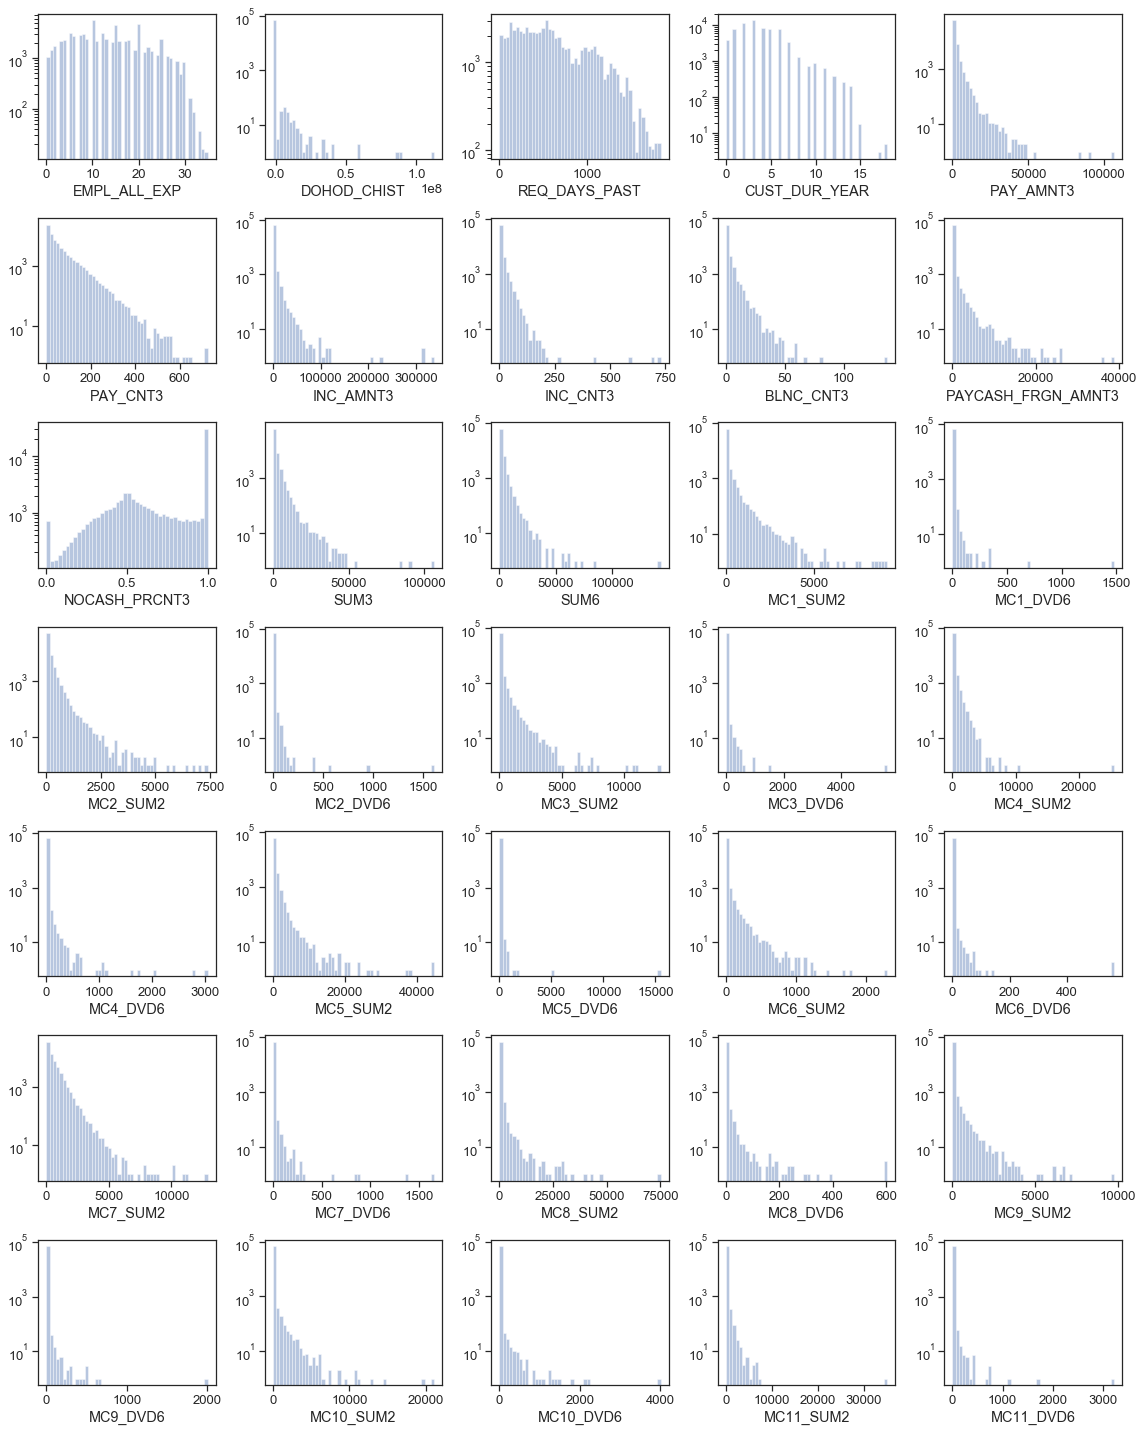

In [23]:
ncols=5 # number of columns
fig, axs = plt.subplots(nrows=len(num_features)//ncols, ncols=ncols, figsize=(16, 20))

j = 0 # row index
for i,feature in enumerate(num_features):
    sns.distplot(train_data[feature].dropna(), color='b',kde=False, ax=axs[j][i-ncols*j]).set_yscale('log')
    if ((i+1)%ncols == 0): j+=1

plt.tight_layout()

<br> 
**SUM3** and **PAY_AMNT3** are identical. Let's drop one of them :

In [24]:
# drop dublicated feature
train_data.drop('SUM3', axis=1, inplace = True)
test_data.drop('SUM3', axis=1, inplace = True)
num_features.remove('SUM3')

 <br> 
Let's transform most of the numerical features so as to reduce the spread of their values :

In [25]:
features_to_transform = [ft for ft in num_features 
                         if ft not in ['EMPL_ALL_EXP','DOHOD_CHIST','REQ_DAYS_PAST','CUST_DUR_YEAR','NOCASH_PRCNT3']]

# functions to transform features
def transNF(pdSeries): return np.log(pdSeries+0.01)

def transformDOHOD_CHIST(pdSeries):
    return pdSeries.map(lambda x:  np.power(x,1/8) if x > 0 else -np.power(-x,1/8))

# transform features
suffix='_transformed'
for i,feature in enumerate(features_to_transform):
    train_data[feature+suffix] = transNF(train_data.pop(feature))  
    test_data[feature+suffix]  = transNF(test_data.pop(feature))

train_data['DOHOD_CHIST_transformed'] = transformDOHOD_CHIST(train_data.pop('DOHOD_CHIST'))
test_data['DOHOD_CHIST_transformed'] = transformDOHOD_CHIST(test_data.pop('DOHOD_CHIST'))

# reselect numeric features column names
num_features = train_data.columns.drop(cat_features + bin_features + ['PPL_AGE','ID']).tolist()

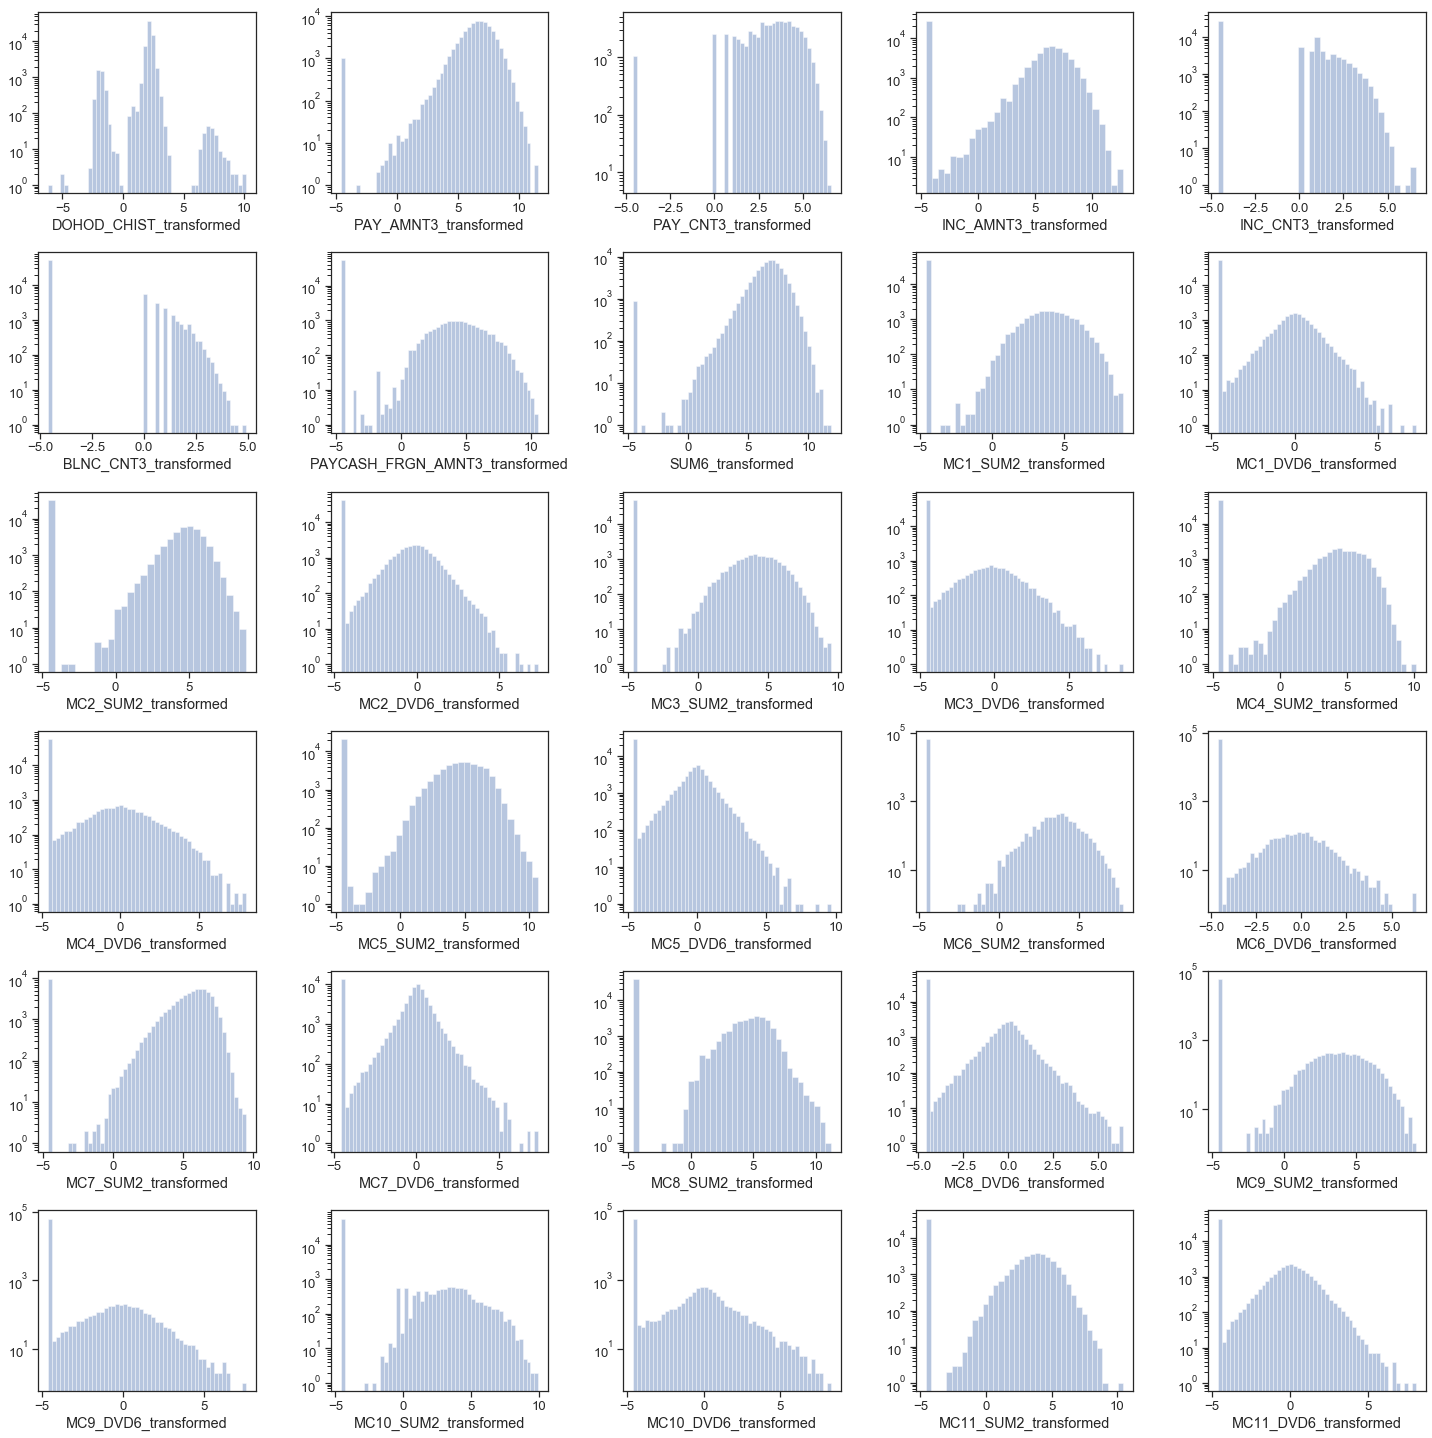

In [26]:
# plot resuts
ncols=5 # number of columns
fig, axs = plt.subplots(nrows=len(features_to_transform)//ncols+1, ncols=ncols, figsize=(20, 20))

j = 0 # row index
for i,feature in enumerate(['DOHOD_CHIST']+features_to_transform):
    sns.distplot( train_data[feature+'_transformed'].dropna(axis=0), 
                 color='b',
                 kde=False, 
                 ax=axs[j][i-ncols*j] ).set_yscale('log')
    if ((i+1)%ncols == 0): j+=1

plt.tight_layout()

___
___
<br> 
**• According to the problem statement, let's select the client age groups** and create a new feature - **PPL_AGE_binned**

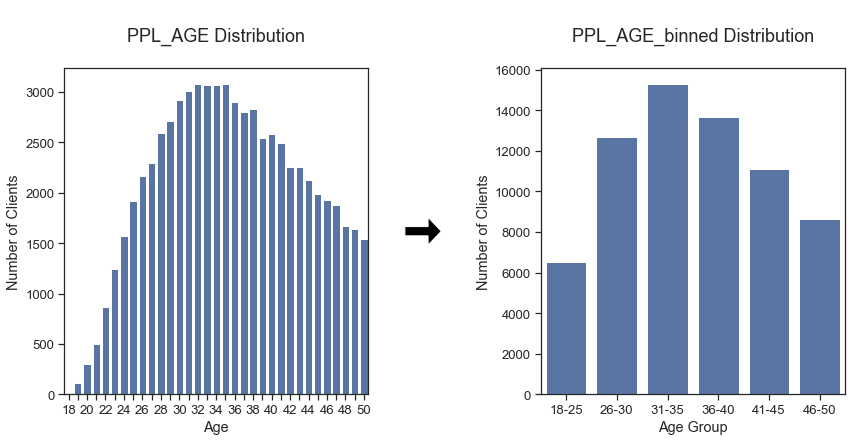

In [27]:
# binning "PPL_AGE" feature
bins_PPL_AGE = [17, 25, 30, 35, 40, 45, 50]
group_names_PPL_AGE = [str(bins_PPL_AGE[i]+1)+'-'+str(bins_PPL_AGE[i+1]) for i in range(len(bins_PPL_AGE)-1)]
train_data['PPL_AGE_binned'] = pd.cut(train_data['PPL_AGE'], 
                                      bins_PPL_AGE, 
                                      labels=group_names_PPL_AGE, 
                                      include_lowest=True).astype('object')

# plot results
fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(9, 10)

ax1 = fig.add_subplot(gs[:, :4])
sns.catplot('PPL_AGE', data=train_data, 
            kind="count", 
            color='b',
            ax=ax1)
ax1.set_xticklabels([label if label in ax1.get_xticklabels()[::2] else "" for label in ax1.get_xticklabels()])
ax1.set_xlabel('Age')
ax1.set_ylabel('Number of Clients')
ax1.set_title("\nPPL_AGE Distribution\n", fontsize=18)


ax2 = fig.add_subplot(gs[4, 4], frameon=False)
ax2.arrow(0.35, 0.5, 0.35, 0,
         facecolor = 'black',          
         width = 0.3,
         head_length = 0.2)
ax2.yaxis.set_visible(False)
ax2.xaxis.set_visible(False)

ax3 = fig.add_subplot(gs[:, -4:])
sns.catplot('PPL_AGE_binned', data=train_data.sort_values(by='PPL_AGE_binned'), 
            kind="count", 
            color='b',
            ax=ax3)
ax3.set_xlabel('Age Group')
ax3.set_ylabel('Number of Clients')
ax3.set_title("\nPPL_AGE_binned Distribution\n", fontsize=18)

plt.close(2)
plt.close(3)

We can see that the data is unbalanced.

<a id="item3"></a>
<h1 align= center>Exploratory Data Analysis</h1>

**•** In order to more accurately determine which features have a statistical relationship with the client age groups, we have to transform the distribution to the uniform one. **Let's make a copy of the train data set and drop part of rows (considering the data “shuffled”) to have the same number of clients in each age group :**

In [28]:
# set the same proportion of target classes
train_data_balanced = train_data.dropna().copy()
max_in_class = train_data_balanced['PPL_AGE_binned'].value_counts().min()
for PPL_AGE_bin in train_data_balanced['PPL_AGE_binned'].unique():
    if (train_data_balanced['PPL_AGE_binned'] == PPL_AGE_bin).sum() > max_in_class:
        to_drop = train_data_balanced.loc[(train_data_balanced['PPL_AGE_binned'] == PPL_AGE_bin)].iloc[max_in_class:].index
        train_data_balanced.drop(to_drop , axis =0, inplace = True)

train_data_balanced.shape[0]

38970

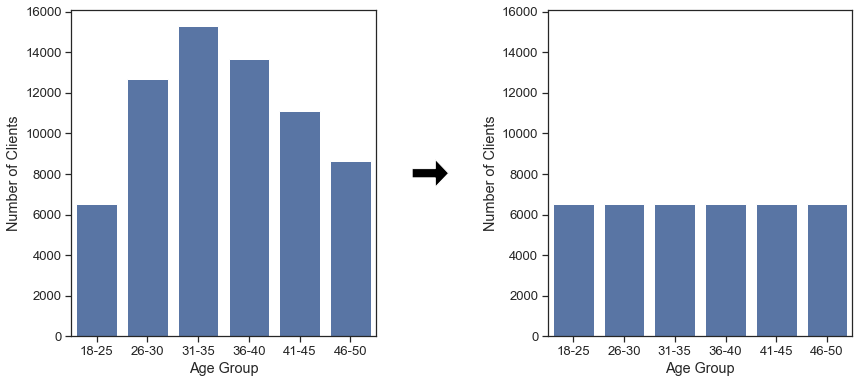

In [29]:
# plot results
fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(9, 10)

ax1 = fig.add_subplot(gs[:, :4])
sns.catplot(x="PPL_AGE_binned", 
                  data=train_data.sort_values(by='PPL_AGE_binned'), 
                  kind="count",
                  color='b',
                  ax=ax1)
ax1.set_xlabel('Age Group')
ax1.set_ylabel('Number of Clients') 

ax2 = fig.add_subplot(gs[4, 4], frameon=False)
ax2.arrow(0.35, 0.5, 0.35, 0,
         facecolor = 'black',          
         width = 0.3,
         head_length = 0.2)
ax2.yaxis.set_visible(False)
ax2.xaxis.set_visible(False)

ax3 = fig.add_subplot(gs[:, -4:])
sns.catplot(x="PPL_AGE_binned",  
                  data=train_data_balanced.sort_values(by='PPL_AGE_binned'), 
                  kind="count",
                  color='b',
                  ax=ax3)
ax3.set_xlabel('Age Group')
ax3.set_ylabel('Number of Clients')
ax3.set_ylim(ax1.get_ylim())

plt.close(2)
plt.close(3)

Let's find out which of the features have the strongest statistical relationship with **PPL_AGE_binned** :     

In [30]:
%%time

train_data_balanced_enc = train_data_balanced.copy()

# Select categorical columns
cat_features = train_data_balanced_enc.columns[train_data_balanced_enc.dtypes == 'object'].drop('PPL_AGE_binned')

# Apply label encoder
train_data_balanced_enc[cat_features] = OrdinalEncoder().fit_transform(train_data_balanced_enc[cat_features])

# Separate target from potential predictors
X_b = train_data_balanced_enc.drop(['PPL_AGE_binned','PPL_AGE','ID'], axis=1)
y_b = train_data_balanced_enc['PPL_AGE_binned']
    
# Estimate mutual information (MI) for the target variable
discrete_features = [ft not in num_features for ft in X_b.columns]
MI_clf = mutual_info_classif(X_b, y_b, discrete_features = discrete_features, random_state=0)

# Show results
fetureImp = pd.DataFrame(index = X_b.columns)
fetureImp['MI -> PPL_AGE_binned'] = MI_clf
fetureImp.sort_values(by = ['MI -> PPL_AGE_binned'], ascending=False).head()

Wall time: 11.1 s


,MI -> PPL_AGE_binned
EMPL_ALL_EXP,0.939941
HOUSE_COND,0.154726
REALTY_EXIST,0.151385
MARR_STAT,0.147860
CUST_DUR_YEAR,0.076197


---
**• Analyzing Individual Feature Patterns using Visualization:**

<a id="#item31"></a>
### EMPL_ALL_EXP

Among all features, only **EMPL_ALL_EXP** (“Total Work Experience”) has a strong statistical relationship with the age of the clients. Let's look at this relationship:

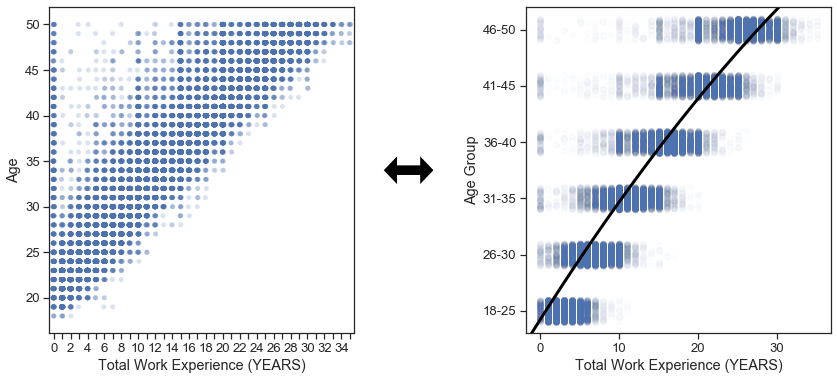

In [31]:
train_data_balanced["PPL_AGE_binned_enc"]=LabelEncoder().fit_transform(train_data_balanced["PPL_AGE_binned"])

fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(9, 10)

ax1 = fig.add_subplot(gs[:, :4])
sns.catplot(x='EMPL_ALL_EXP', y="PPL_AGE", data=train_data_balanced, 
                color='b',
                alpha = 0.2,
                ax=ax1)
ax1.set_xticklabels([label if label in ax1.get_xticklabels()[::2] else "" for label in ax1.get_xticklabels()])
ax1.set_ylabel('Age')
ax1.set_xlabel('Total Work Experience (YEARS)') 


ax2 = fig.add_subplot(gs[4, 4], frameon=False)
ax2.arrow(0.45, 0.5, 0.35, 0,
         facecolor = 'black', 
         linewidth = 0,        
         width = 0.3,
         head_length = 0.2)
ax2.arrow(0.8, 0.5, -0.35, 0,
         facecolor = 'black',  
         linewidth = 0,        
         width = 0.3,
         head_length = 0.2)
ax2.yaxis.set_visible(False)
ax2.xaxis.set_visible(False)

ax3 = fig.add_subplot(gs[:, -4:])
sns.regplot(x='EMPL_ALL_EXP', y= "PPL_AGE_binned_enc", 
                data=train_data_balanced.sort_values(by='PPL_AGE_binned',ascending=False), 
                y_jitter=.2,
                line_kws = {'color': 'black','lw': 3},
                scatter_kws={'alpha': 0.01},
                order = 2,
                ax=ax3)

ax3.set_ylim((-0.4,5.4))
ax3.set_ylabel('Age Group')
ax3.set_xlabel('Total Work Experience (YEARS)') 
ax3.set_yticklabels([' ']+train_data_balanced.sort_values(by='PPL_AGE_binned').PPL_AGE_binned.unique().tolist())

plt.close(2)
plt.close(3)

___
<a id="#item32"></a>
### REALTY_EXIST

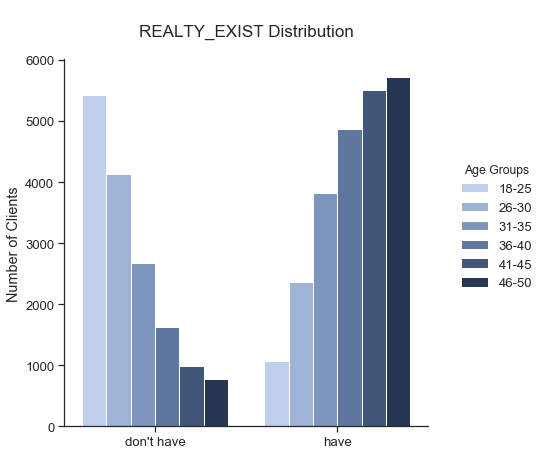

In [32]:
g = sns.catplot(x='REALTY_EXIST', hue="PPL_AGE_binned", 
                  data=train_data_balanced.sort_values(by='PPL_AGE_binned'), 
                  kind="count",
                  aspect = 1,
                  height = 6,
                  palette="ch:2.8,r=0,h=1,l=0.8,d=0.2")
g.set_axis_labels('', "Number of Clients")
g._legend.set_title('Age Groups')
g.set_xticklabels(["don't have",'have'])
plt.title("\nREALTY_EXIST Distribution\n", fontsize=17)
plt.show()

___
<a id="#item33"></a>
### HOUSE_COND 
(the age distribution in the category **'в собственном доме/квартире'** does not visually differ from the distribution **REALTY_EXIST**, therefore we will not illustrate it here)

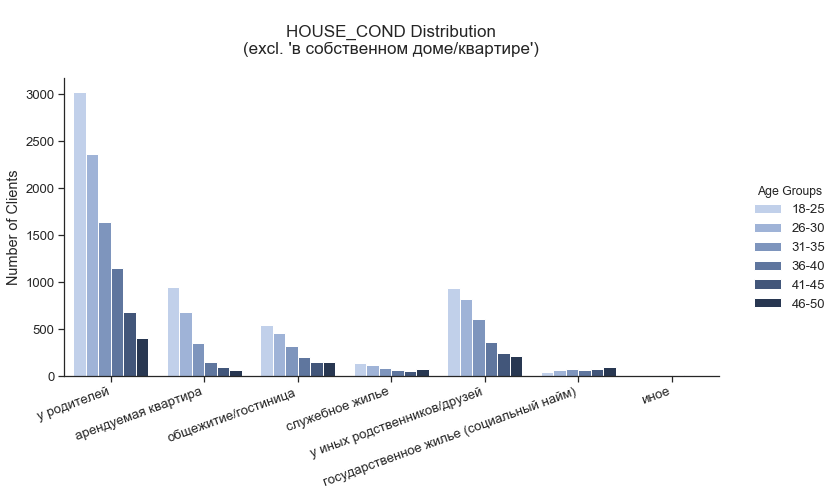

In [33]:
g = sns.catplot(x='HOUSE_COND', hue="PPL_AGE_binned", 
                  data=train_data_balanced\
                                          .sort_values(by='PPL_AGE_binned')\
                                          .loc[train_data_balanced['HOUSE_COND']!='в собственном доме/квартире'], 
                  kind="count",
                  aspect = 2,
                  palette="ch:2.8,r=0,h=1,l=0.8,d=0.2")
g.set_axis_labels('', "Number of Clients")
g._legend.set_title('Age Groups')
g.set_xticklabels(rotation=20, horizontalalignment='right')
plt.title("\nHOUSE_COND Distribution\n(excl. 'в собственном доме/квартире')\n", fontsize=17)
plt.show()

___
<a id="#item34"></a>
### MARR_STAT

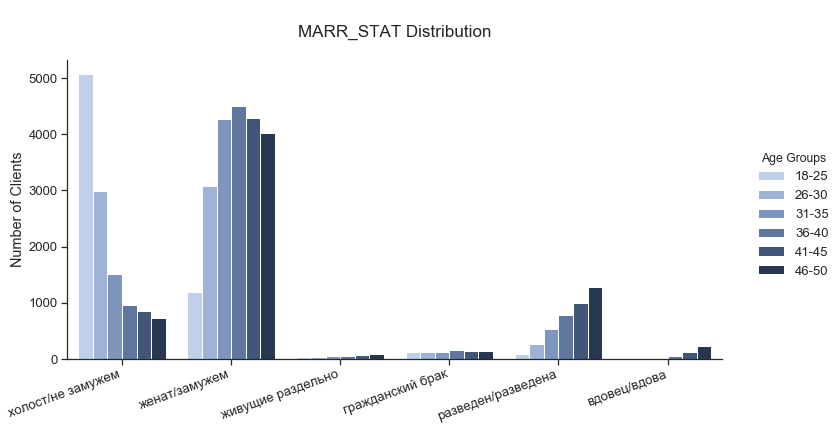

In [34]:
g = sns.catplot(x='MARR_STAT', hue="PPL_AGE_binned", 
                  data=train_data_balanced.sort_values(by='PPL_AGE_binned'), 
                  kind="count",
                  aspect = 2,
                  palette="ch:2.8,r=0,h=1,l=0.8,d=0.2")
g.set_axis_labels('', "Number of Clients")
g._legend.set_title('Age Groups')
g.set_xticklabels(rotation=20, horizontalalignment='right')
plt.title("\nMARR_STAT Distribution\n", fontsize=17)
plt.show()

____
<a id="#item35"></a>
### CUST_DUR_YEAR

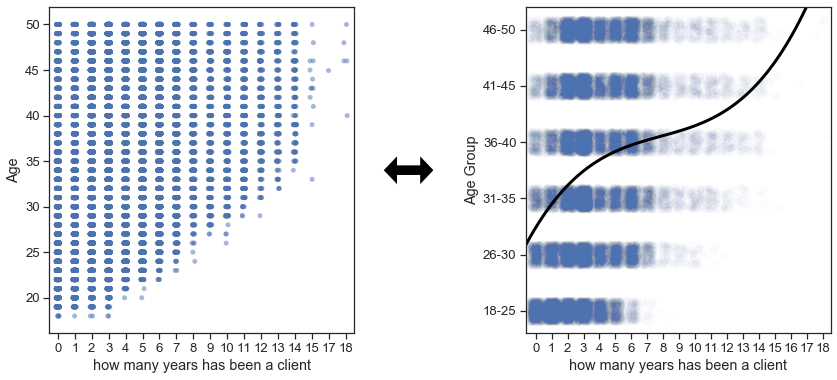

In [35]:
fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(9, 10)

ax1 = fig.add_subplot(gs[:, :4])
sns.catplot(x='CUST_DUR_YEAR', y="PPL_AGE", data=train_data_balanced, 
                color='b',
                alpha = 0.5,
                ax=ax1)
ax1.set_ylabel('Age')
ax1.set_xlabel('how many years has been a client') 


ax2 = fig.add_subplot(gs[4, 4], frameon=False)
ax2.arrow(0.45, 0.5, 0.35, 0,
         facecolor = 'black', 
         linewidth = 0,        
         width = 0.3,
         head_length = 0.2)
ax2.arrow(0.8, 0.5, -0.35, 0,
         facecolor = 'black',  
         linewidth = 0,        
         width = 0.3,
         head_length = 0.2)
ax2.yaxis.set_visible(False)
ax2.xaxis.set_visible(False)

ax3 = fig.add_subplot(gs[:, -4:])
sns.regplot(x='CUST_DUR_YEAR', y= "PPL_AGE_binned_enc", 
                data=train_data_balanced.sort_values(by='PPL_AGE_binned',ascending=False), 
                x_jitter=.4,
                y_jitter=.2,
                line_kws = {'color': 'black','lw': 3},
                scatter_kws={'alpha': 0.01},
                ci=None,
                order = 3,
                ax=ax3)
ax3.set_ylim((-0.4,5.4))
ax3.set_xlim((-0.6,18.5))
ax3.set_ylabel('Age Group')
ax3.set_xlabel('how many years has been a client')
ax3.set_yticklabels([' ']+train_data_balanced.sort_values(by='PPL_AGE_binned').PPL_AGE_binned.unique().tolist())
ax3.set_xticks([i for i in range(19)])

plt.close(2)
plt.close(3)

____

<a id="item4"></a>
<h1 align= center>Model Development and Evaluation</h1>

**•** In order to predict the age group of the client, we will use a combination of multiclass classifiers:

In [36]:
# Separate target from predictors
y = train_data['PPL_AGE_binned']
X = train_data.drop(['PPL_AGE_binned','PPL_AGE','ID'], axis=1)

# Break off validation set from training data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, 
                                                      test_size=0.1,
                                                      random_state=0)
# Take selected columns from test data
X_test = test_data[X.columns]

# Find columns with missing values in train and test data
columns_with_missing_values = [column for column in X.columns 
                                   if X[column].isna().sum() > 0 
                                    or X_test[column].isna().sum() > 0]

# Select binary, categorical and numerical columns
bin_features = ['AVTO_EXIST','REALTY_EXIST']
cat_features = X.columns[X.dtypes == 'object'].tolist()
num_features = X.columns.drop(cat_features + bin_features).tolist()

# Bundle preprocessing
preprocessor =   make_column_transformer(
                                         (StandardScaler(), 
                                             [ft for ft in num_features if ft not in columns_with_missing_values]),
                                         (Pipeline([('SimpleImputer',SimpleImputer(strategy="median")),
                                                     ('StandardScaler',StandardScaler())],memory = 'cachedir'), 
                                             [ft for ft in num_features if ft in columns_with_missing_values]),
                                         (OneHotEncoder(), 
                                             [ft for ft in cat_features if ft not in columns_with_missing_values]),
                                         (Pipeline([('SimpleImputer',SimpleImputer(strategy="most_frequent")),
                                                    ('OneHotEncoder',OneHotEncoder())],memory = 'cachedir'), 
                                             [ft for ft in cat_features if ft in columns_with_missing_values]),
                                         remainder='passthrough'
                                        )

# Define models 
clfXGB = XGBClassifier(tree_method = "gpu_hist", predictor = "gpu_predictor", 
                        n_estimators=125, max_depth=3, reg_alpha = 0.015 ,
                        min_child_weight=0, subsample= 0.85,  colsample_bytree= 0.9,
                        random_state=0,
                        n_jobs= -1)

clfHGB = HistGradientBoostingClassifier(learning_rate=0.05, 
                                        l2_regularization=0.001, 
                                        n_iter_no_change = 20,
                                        random_state=0)

clfMLP = MLPClassifier( hidden_layer_sizes = (10,8), random_state=0)

# Stack of estimators with a final classifier
estimators = [('Gradient Boosting',  make_pipeline(preprocessor,clfXGB) ),
              ('Gradient Boosting2', make_pipeline(preprocessor,clfHGB) ),
              ('Neural Network',     make_pipeline(preprocessor,clfMLP) )]

stacking_classifier = StackingClassifier(estimators = estimators, 
                                         final_estimator = LogisticRegression(max_iter = 500, C=0.5))

**•** We will train the model on the part of the train data set, make a prediction based on the remaining part of the data and find out how accurately the model classifies clients of each age group:

In [37]:
%%time
stclf = stacking_classifier.fit(train_X,train_y)
y_pred = stclf.predict(valid_X)

print(classification_report(valid_y, y_pred))

              precision    recall  f1-score   support

       18-25       0.78      0.76      0.77       667
       26-30       0.65      0.71      0.68      1236
       31-35       0.64      0.67      0.66      1500
       36-40       0.63      0.63      0.63      1371
       41-45       0.63      0.63      0.63      1097
       46-50       0.84      0.69      0.75       924

    accuracy                           0.68      6795
   macro avg       0.70      0.68      0.69      6795
weighted avg       0.68      0.68      0.68      6795

Wall time: 6min


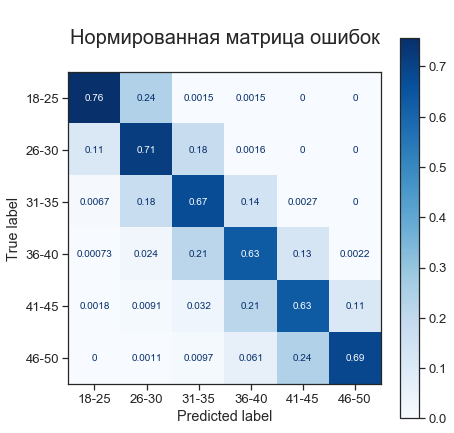

In [38]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(stclf, valid_X, valid_y,
                      cmap=plt.cm.Blues,
                      normalize='true', ax=ax)
ax.set_title("\nНормированная матрица ошибок\n",fontsize = 20)

plt.show()

Using the cross-validation on the entire train data set, let's more accurately calculate the percentage of correctly qualified clients among all clients in each age group, averaged by all age groups:

In [39]:
cvs = cross_val_score(stacking_classifier, X, y,
                      scoring = 'balanced_accuracy',
                      cv = 5,
                      n_jobs = -1,
                      verbose = 1)
print('{:.4f} ({:.4f})'.format( cvs.mean() , cvs.std() ) )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.5min finished


0.6806 (0.0023)


**• Let's make a prediction using the test data set**, having previously trained model on the entire train data set:

In [40]:
%%time

stclf = stacking_classifier.fit(X,y)
y_pred = stclf.predict(X_test)

output = pd.DataFrame({'ID': test_data.ID, "возрастная группа": y_pred})
output.to_csv('Sergey Fialka_submission_.csv', index=False, encoding = 'cp1251')
print('saved')

saved
Wall time: 6min 38s
